# Summary

In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

#### 1. Load data

In [2]:
unet_output = xr.open_mfdataset('./data/unet_output.nc4')
segnet_output = xr.open_mfdataset('./data/segnetlite_output.nc4')
vgg_output = xr.open_mfdataset('./data/vgg16_output.nc4')
observations = xr.open_mfdataset('./data/mismatch.nc4')

unet_mismatch = unet_output['mismatch_pred']
segnet_mismatch = segnet_output['mismatch_pred']
vgg_mismatch = vgg_output['mismatch_pred']

grace = observations['grace'][2:,:,:]
gldas = observations['gldas'][2:,:,:]
obs_mismatch = observations['mismatch'][2:,:,:]

india_shp = gpd.read_file("data/India_shp/india.shp")

#### 2. Compute CNN-corrected TWSA

In [3]:
unet_twsa = gldas - unet_mismatch
segnet_twsa = gldas - segnet_mismatch
vgg_twsa = gldas - vgg_mismatch

#### 3. Visualise different versions for one time frame

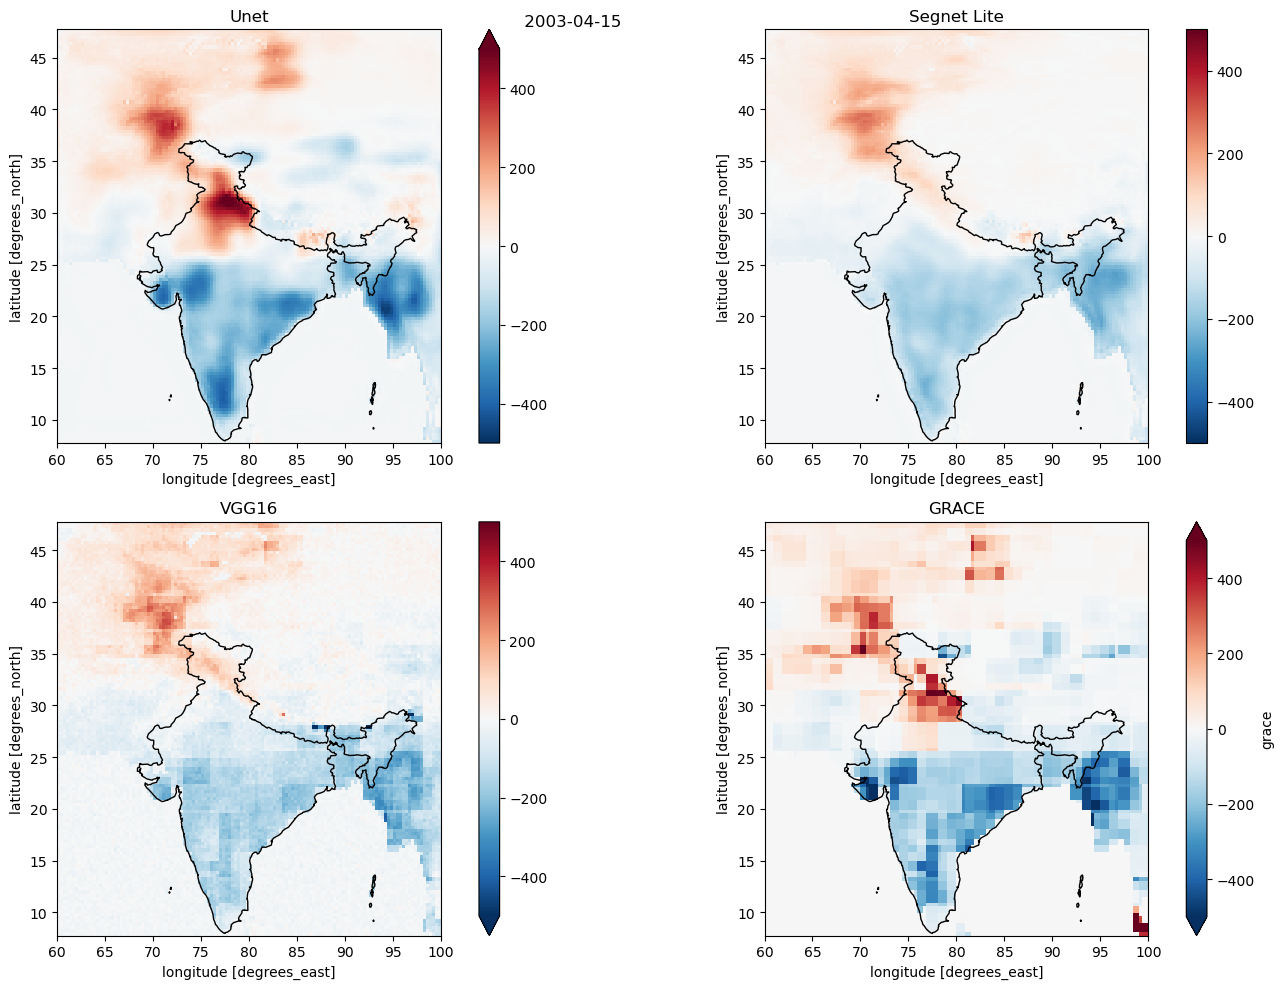

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

t = 10
unet_twsa.isel(time=t).plot(ax=axes[0, 0], cmap='RdBu_r', vmin=-500, vmax=500)
india_shp.plot(ax=axes[0,0], edgecolor='black', color='none')
axes[0, 0].set_title('Unet')

segnet_twsa.isel(time=t).plot(ax=axes[0, 1], cmap='RdBu_r', vmin=-500, vmax=500)
india_shp.plot(ax=axes[0,1], edgecolor='black', color='none')
axes[0, 1].set_title('Segnet Lite')

vgg_twsa.isel(time=t).plot(ax=axes[1, 0], cmap='RdBu_r', vmin=-500, vmax=500)
india_shp.plot(ax=axes[1,0], edgecolor='black', color='none')
axes[1, 0].set_title('VGG16')

grace.isel(time=t).plot(ax=axes[1, 1], cmap='RdBu_r', vmin=-500, vmax=500)
india_shp.plot(ax=axes[1,1], edgecolor='black', color='none')
axes[1, 1].set_title('GRACE')

plt.tight_layout()
plt.suptitle(f" {str(unet_twsa['time'][t].values.astype('datetime64[D]'))}")
plt.show()

#### 4. Plot time series for an example location in NW India (30N 80E)
Same location as in [3_Mismatch](3_Mismatch.ipynb) (an extreme case)

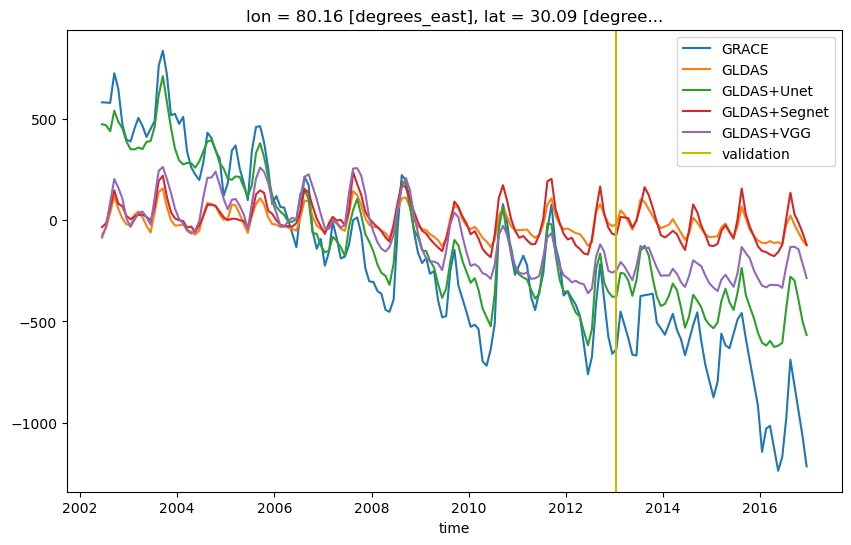

In [5]:
lat, lon = 30, 80
plt.figure(figsize=(10,6))

grace.sel(lat=lat, lon=lon, method='nearest').plot(label="GRACE")
gldas.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS")
unet_twsa.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS+Unet")
segnet_twsa.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS+Segnet")
vgg_twsa.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS+VGG")

plt.axvline(x = grace.time.values[127], color = 'y', label = 'validation')
plt.legend()

#### 5. Plot time series for an example location in S India (13N 77E)

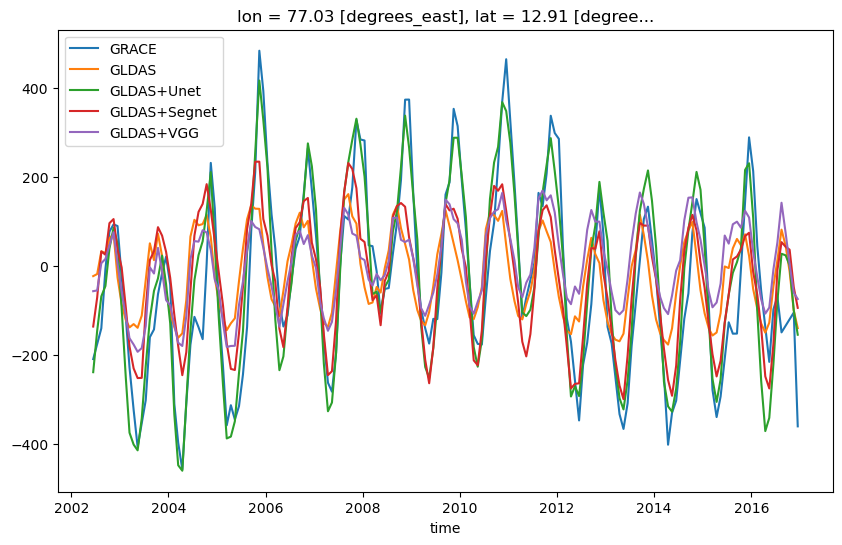

In [6]:
lat, lon = 13,77
plt.figure(figsize=(10,6))

grace.sel(lat=lat, lon=lon, method='nearest').plot(label="GRACE")
gldas.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS")
unet_twsa.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS+Unet")
segnet_twsa.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS+Segnet")
vgg_twsa.sel(lat=lat, lon=lon, method='nearest').plot(label="GLDAS+VGG")

plt.legend()

#### 6. Calculate performance metrics
Nash-Sutcliff efficiency (NSE) and Pearson's correlation coefficient between the trained models and GRACE

In [7]:
# temp projection fix
unet_mismatch.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
unet_mismatch.rio.write_crs('epsg:4326', inplace=True)

segnet_mismatch.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
segnet_mismatch.rio.write_crs('epsg:4326', inplace=True)

vgg_mismatch.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
vgg_mismatch.rio.write_crs('epsg:4326', inplace=True)

unet_mismatch.rio.crs

CRS.from_epsg(4326)

In [8]:
from metrics import custom_nse, custom_corr

# calculate metrics for India only
grace_india = grace.rio.clip(india_shp.geometry.values, india_shp.crs, drop=False)
gldas_india = gldas.rio.clip(india_shp.geometry.values, india_shp.crs, drop=False)
unet_mis_india = unet_mismatch.rio.clip(india_shp.geometry.values, india_shp.crs, drop=False)
segnet_mis_india = segnet_mismatch.rio.clip(india_shp.geometry.values, india_shp.crs, drop=False)
vgg_mis_india = vgg_mismatch.rio.clip(india_shp.geometry.values, india_shp.crs, drop=False)

# training set
base_nse_tr = custom_nse(grace_india[:125], gldas_india[:125], xr.zeros_like(gldas_india[:125]))
unet_nse_tr = custom_nse(grace_india[:125], gldas_india[:125], unet_mis_india[:125])
segnet_nse_tr = custom_nse(grace_india[:125], gldas_india[:125], segnet_mis_india[:125])
vgg_nse_tr = custom_nse(grace_india[:125], gldas_india[:125], vgg_mis_india[:125])

base_corr_tr = custom_corr(grace_india[:125], gldas_india[:125], xr.zeros_like(gldas_india[:125]))
unet_corr_tr = custom_corr(grace_india[:125], gldas_india[:125], unet_mis_india[:125])
segnet_corr_tr = custom_corr(grace_india[:125], gldas_india[:125], segnet_mis_india[:125])
vgg_corr_tr = custom_corr(grace_india[:125], gldas_india[:125], vgg_mis_india[:125])

# testing set
base_nse_ts = custom_nse(grace_india[125:], gldas_india[125:], xr.zeros_like(gldas_india[125:]))
unet_nse_ts = custom_nse(grace_india[125:], gldas_india[125:], unet_mis_india[125:])
segnet_nse_ts = custom_nse(grace_india[125:], gldas_india[125:], segnet_mis_india[125:])
vgg_nse_ts = custom_nse(grace_india[125:], gldas_india[125:], vgg_mis_india[125:])

base_corr_ts = custom_corr(grace_india[125:], gldas_india[125:], xr.zeros_like(gldas_india[125:]))
unet_corr_ts = custom_corr(grace_india[125:], gldas_india[125:], unet_mis_india[125:])
segnet_corr_ts = custom_corr(grace_india[125:], gldas_india[125:], segnet_mis_india[125:])
vgg_corr_ts = custom_corr(grace_india[125:], gldas_india[125:], vgg_mis_india[125:])

In [9]:
pd.DataFrame({
        'Corr_train': [base_corr_tr, vgg_corr_tr, unet_corr_tr, segnet_corr_tr],
        'NSE_train': [base_nse_tr, vgg_nse_tr, unet_nse_tr, segnet_nse_tr],
        'Corr_test': [base_corr_ts, vgg_corr_ts, unet_corr_ts, segnet_corr_ts],
        'NSE_test': [base_nse_ts, vgg_nse_ts, unet_nse_ts, segnet_nse_ts]},
    index=['GLDAS', 'GLDAS+VGG', 'GLDAS+Unet', 'GLDAS+Segnet'])

,Corr_train,NSE_train,Corr_test,NSE_test
GLDAS,0.6314925721406135,0.7868283033697315,0.45493838522397445,0.42075766304520734
GLDAS+VGG,0.8151656749233672,0.8954856568253985,0.7708057535240903,0.7059580034627968
GLDAS+Unet,0.9168808966468965,0.9725249807711489,0.8064344180537163,0.682181933822098
GLDAS+Segnet,0.7670387392511737,0.9400519519389041,0.5696993679075146,0.6197344816814272
